- Mạng nơ-ron tế bào bậc hai có cấu trúc tương tự như bậc nhất, chỉ là thay vì có 1 ma trận điều khiển B, 1 ma trận phản hồi A và mức ngưỡng I như mạng Nơ-ron tế bào bậc nhất thì bậc hai có 10 ma trận điều khiến (gồm 1 ma trận B1 và 9 ma trận lần lượt là B21 đến B29), 10 ma trận phản hồi (gồm 1 ma trận A1 và 9 ma trận A21 đến A29) và mức ngưỡng I.
- Do các ma trận đều đối xứng để đảm bảo tính ổn định cho mạng, nên quần thể sẽ gồm (1+9+1+9)*5+1=101 trọng số.

In [47]:
from numba import njit
from scipy.signal import convolve2d
from scipy.integrate import ode
from PIL import Image as img
import numpy as np
from numba.typed import List

Khai báo các hàm và các ma trận
- Ma trận A21 - A29 tương ứng với mảng A2[0] - A2[8] (tương ứng với B2)

In [56]:
# hàm trạng thái
def hamTrangThai(t, x, uB1, uB2, A1, A2, I, n, m):
    x = x.reshape(n, m)
    dx = -x + uB1 + convolve2d(hamDauRa(x),A1,'same') + uB2 + TichChapBacHai(hamDauRa(x),A2) + I
    return dx.reshape(n*m)

# hàm đầu ra
def hamDauRa(x):
    return 0.5 * (abs(x + 1) - abs(x - 1))

# # hàm tính tích chập của các ma trận A21 - A29 với ma trận đầu ra y (hoặc B21 - B29 với u) (xem lại công thức mạng Nơ-ron tế bào bậc hai)
# def TichChapBacHai(y,A):
#     A_numba = List()
#     for x in A:
#         A_numba.append(x)
#     return TichChapBacHai_numba(y, A_numba)

# Hàm tính tích chập bậc hai chạy trên GPU thông qua thư viện Numba (vì chạy trên CPU quá chậm)
@njit()
#def TichChapBacHai_numba(y, A):
def TichChapBacHai(y, A):
    m, n = y.shape
    ketQua = np.zeros(y.shape) # tạo ma trận 0 có kích thước bằng ma trận y để lưu kết quả
    for i in range(m):
        for j in range(n):
            # xét từng điểm trên ma trận y kích thước m, n
            for k in range(3):#0.. 2
                for l in range(3):#0.. 2
                    # xét từng ma trận trong bộ A21 đến A29 (trong code là A[0] đến A[8])
                    x = k*3+l # ma trận A[x] đang được xét
                    for r in range(-1,2):#-1.. 1
                        for s in range(-1,2):#-1.. 1
                            # nhân từng số của ma trận láng giềng y(i,j;r,s) với ma trận A[x]
                            if(0<=i+r<m and 0<=j+s<n and 0<=i+1-k<m and 0<=j+1-l<n):
                                ketQua[i][j]+=A[x][r][s]*y[i+1-k][j+1-l]*y[i+r][j+s]
    return ketQua

# Tạo ma trận đối xứng từ 5 trọng số (hàm này chỉ dành riêng cho ma trận đối xứng 3x3)
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    #arr2[0], arr2[2] = arr2[2], arr2[0]#nếu có thì sẽ đối xứng theo đường chéo phụ, nếu không thì sẽ là đối xứng tâm
    return np.append(arr1,arr2).reshape(h,h)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3

# Hàm lai hai số (lai 50/50, dấu cũng được coi là một nhiễm sắc thể)
def lai(a,b):#k là điểm lai  -3,|45
    if(a>0):
        return round(a//1+abs(b)-abs(b)//1,2)
    else:
        return round(-(-a//1)-abs(b)+abs(b)//1,2)

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# Hàm tính sai số
def saiSo(d,y):
    return np.sum(0.5*(d-y)**2)

# Bán kính lân cận của nơ ron tế bào
r = 1

# kích thước của ma trận điều khiển và ma trận phản hồi (hai ma trận này luôn vuông)
h = 2*r + 1 # h = 3

class CNN:

    # ma trận ảnh đầu vào u
    u = np.array(img.open('images/u1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

    # ma trận đầu ra mong muốn d
    d = np.array(img.open('images/d1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

    # kích thước ma trận đầu vào, ma trận đầu ra và ma trận trạng thái
    m, n = u.shape
    print(m,n)

    slts = 101 # số lượng trọng số trong quần thể

    # Quần thể trọng số (gồm 11 số)
    #quanThe = np.array([ngauNhien() for i in range(slts)])
    quanThe = np.array([2.,2.,2.,2.,2.]*20+[2.])# các ma trận A1, A21 - A29, B1, B21 - B29 ban đầu đều là ma trận 0 với tâm là 2, mức ngưỡng I ban đầu là -1

    # Khởi tạo các ma trận A1, A21 - A29, B1, B21 - B29 ban đầu
    A1 = taoMaTranDoiXung(quanThe[:5])
    A2=[]
    for i in range(9):
        A2+=[taoMaTranDoiXung(quanThe[5*i+5:5*i+10])]

    B1 = taoMaTranDoiXung(quanThe[50:55])
    B2=[]
    for i in range(9):
        B2+=[taoMaTranDoiXung(quanThe[5*i+55:5*i+60])]    

    # mức ngưỡng I ban đầu
    I = quanThe[100]

    # hai giá trị ban đầu cho ptvp gồm x0 = [ma trận toàn số 0] với t0 = 0.0 và t1 để tính đầu ra x1 (t1 != t0)
    x0, t0, t1 = u*0.0, 0.0, 0.25

    # ma trận đầu ra y (y được tính theo x)
    y = hamDauRa(x0)

    # sai số cho phép
    E0 = 4.0

    # sai số hiện tại
    E = float('inf') # mặc định ban đầu gán với dương vô cùng

cnn = CNN()

# Hàm tối ưu trọng số thứ i trong quần thể
def toiUuTrongSo(i, k, soChaMe): #k là lần chạy thứ k của vòng lặp lớn
    tapChaMe = [[ngauNhien(),ngauNhien()] for i in range(soChaMe)]
    tapCon = [lai(chaMe[0],chaMe[1]) for chaMe in tapChaMe]
    if(k == 1):
        print(f'Tập cha mẹ: {tapChaMe}')
        print(f'Tập con: {tapCon}')
        print('Xét từng cặp cha mẹ:')
    for con in tapCon:
        quanTheMoi = cnn.quanThe.copy()
        quanTheMoi[i] = con
        A1Con = taoMaTranDoiXung(quanTheMoi[:5])
        A2Con=[]
        for i in range(9):
            A2Con+=[taoMaTranDoiXung(quanTheMoi[5*i+5:5*i+10])]
        B1Con = taoMaTranDoiXung(quanTheMoi[50:55])
        B2Con=[]
        for i in range(9):
            B2Con+=[taoMaTranDoiXung(quanTheMoi[5*i+55:5*i+60])]
        ICon = quanTheMoi[100]
        ptvp.set_initial_value(cnn.x0.flatten(), cnn.t0)
        ptvp.set_f_params(convolve2d(cnn.u,B1Con,'same'), TichChapBacHai(cnn.u,B2Con), A1Con, A2Con, ICon, cnn.n, cnn.m)
        xCon = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
        yCon = hamDauRa(xCon)
        yCon = np.sign(yCon)
        ECon = saiSo(cnn.d,yCon)
        if(k == 1):
            print(f'Sai số ứng với con = {con} là: E = {ECon}')
        if(ECon <= cnn.E):
            cnn.y = yCon.copy()
            #cnn.u = xCon.copy()
            cnn.quanThe = quanTheMoi.copy()
            cnn.E = ECon
            cnn.A1 = A1Con.copy()
            cnn.B1 = B1Con.copy()
            cnn.A2 = A2Con.copy()
            cnn.B2 = B2Con.copy()
            cnn.I = ICon

# khởi tạo phương trình vi phân
ptvp = ode(hamTrangThai) 
ptvp.set_integrator('vode') # thuật toán được sử dụng để giải ptvp, đọc thêm trong tài liệu
ptvp.set_initial_value(cnn.x0.flatten(), 0.0) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)

print(f'u = {cnn.u}')
print(f'd = {cnn.d}')

# các tham số uB1, uB2, A1, A2, I, n, m
ptvp.set_f_params(convolve2d(cnn.u,cnn.B1,'same'), TichChapBacHai(cnn.u,cnn.B2), cnn.A1, cnn.A2, cnn.I, cnn.n, cnn.m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
cnn.y = np.sign(y)
print(f'y = {cnn.y}')
cnn.E = saiSo(cnn.d,cnn.y)
print(f'E = {cnn.E}')

8 8
u = [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]
d = [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]]


d:\anaconda\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'A' of function 'TichChapBacHai'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\phamd\AppData\Local\Temp\ipykernel_11716\3721817660.py", line 20:
@njit()
#def TichChapBacHai_numba(y, A):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


y = [[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]
E = 32.0


In [57]:
# thuật toán tối ưu từng trọng số theo phương pháp ngẫu nhiên
soChaMe = 2 # số cha mẹ được chọn để lai mới mỗi trọng số 
loop = 200 #số lần chạy thử tối đa
count = 0 # đếm số lần chạy
while(True):
    # kiểm tra ptvp ODE
    if(not ptvp.successful()):
        print('Lỗi phương trình vi phân')
        print(f'Mã lỗi: {ptvp.get_return_code()}')
        break

    # xét trọng số
    ts = count%cnn.slts # STT trọng số hiện tại đang được lai (trọng số lai)

    # đếm số lần chạy
    if(count>loop*cnn.slts):
        print('Đạt đến số vòng lặp tối đa')
        break
    else:
        print(f'Lần chạy thứ {count//cnn.slts+1}')
        print(f'Xét trọng số thứ {ts%5+1} của ma trận {"A" if ts<50 else "B"}{1 if ts%50<5 else 2}{"" if ts%50//5==0 else ts%50//5}:')
    toiUuTrongSo(ts, count//cnn.slts+1, soChaMe)

    if(count == cnn.slts-1):
        print(f'A1 = {cnn.A1}')
        for i in range(len(cnn.A2)):
            print(f'A2{i+1} = {cnn.A2[i]}')
        print(f'B1 = {cnn.B1}')
        for i in range(len(cnn.B2)):
            print(f'B2{i+1} = {cnn.B2[i]}')
        print(f'I = {cnn.I}')
    print(f'E = {cnn.E}')

    # kiểm tra sai số
    if(cnn.E <= cnn.E0):
        print('Đạt đến mức sai số cho phép')
        break

    count+=1

print('Bộ trọng sau khi tối ưu: ')
print(f'A1 = {cnn.A1}')
for i in range(len(cnn.A2)):
    print(f'A2{i+1} = {cnn.A2[i]}')
print(f'B1 = {cnn.B1}')
for i in range(len(cnn.B2)):
    print(f'B2{i+1} = {cnn.B2[i]}')
print(f'I = {cnn.I}')
print(f'E = {cnn.E}')

Lần chạy thứ 1
Xét trọng số thứ 1 của ma trận A1:
Tập cha mẹ: [[-3.42, 4.13], [-5.51, 0.16]]
Tập con: [-3.13, -5.16]
Xét từng cặp cha mẹ:
Sai số ứng với con = -3.13 là: E = 32.0
Sai số ứng với con = -5.16 là: E = 32.0
E = 32.0
Lần chạy thứ 1
Xét trọng số thứ 2 của ma trận A1:
Tập cha mẹ: [[-1.79, -2.93], [-8.49, 0.84]]
Tập con: [-1.93, -8.84]
Xét từng cặp cha mẹ:
Sai số ứng với con = -1.93 là: E = 32.0
Sai số ứng với con = -8.84 là: E = 32.0
E = 32.0
Lần chạy thứ 1
Xét trọng số thứ 3 của ma trận A1:
Tập cha mẹ: [[-5.87, -5.73], [-6.78, -6.95]]
Tập con: [-5.73, -6.95]
Xét từng cặp cha mẹ:
Sai số ứng với con = -5.73 là: E = 32.0
Sai số ứng với con = -6.95 là: E = 32.0
E = 32.0
Lần chạy thứ 1
Xét trọng số thứ 4 của ma trận A1:
Tập cha mẹ: [[7.6, 7.5], [-2.24, 8.91]]
Tập con: [7.5, -2.91]
Xét từng cặp cha mẹ:
Sai số ứng với con = 7.5 là: E = 32.0
Sai số ứng với con = -2.91 là: E = 32.0
E = 32.0
Lần chạy thứ 1
Xét trọng số thứ 5 của ma trận A1:
Tập cha mẹ: [[-9.3, 8.07], [1.06, 6.64]]
Tập c

In [58]:
# Lưu lại bộ trọng số
np.savetxt('TrongSoBac2/A1.txt',cnn.A1)
for i in range(9):
    np.savetxt(f'TrongSoBac2/A2{i+1}.txt',cnn.A2[i])
np.savetxt('TrongSoBac2/B1.txt',cnn.B1)
for i in range(9):
    np.savetxt(f'TrongSoBac2/B2{i+1}.txt',cnn.B2[i])
np.savetxt('TrongSoBac2/I.txt',np.array([cnn.I]))
print('Đã lưu')

Đã lưu


In [59]:
# testA = np.loadtxt('TrongSo/A.txt')
# testB = np.loadtxt('TrongSo/B.txt')
# testI = np.loadtxt('TrongSo/I.txt')
# print(f'A = {testA}')
# print(f'B = {testB}')
# print(f'I = {testI}')
ptvp.set_initial_value(cnn.x0.flatten(), 0.0)
ptvp.set_f_params(convolve2d(cnn.u,cnn.B1,'same'), TichChapBacHai(cnn.u,cnn.B2), cnn.A1, cnn.A2, cnn.I, cnn.n, cnn.m)
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
y = np.sign(y)
print('y = ')
print(y)
print(f'sai số: {saiSo(cnn.d,y)}')

y = 
[[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1. -1. -1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.  1.]]
sai số: 4.0


(256, 256)


d:\anaconda\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1012: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


y = [[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
done


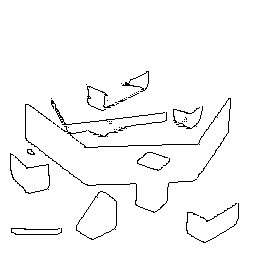

In [60]:
#test với ảnh mẫu
maTranAnh = img.open('images/input1.bmp').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
#maTranAnh = img.open('images/input4.jpg').convert('RGB')
#maTranAnh = img.open('images/input5.png').convert('RGB')
#maTranAnh = img.open('images/input6.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.array(maTranAnh)[:,:,0]
print(u.shape)
u = u/255.0*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(convolve2d(u,cnn.B1,'same'), TichChapBacHai(u,cnn.B2), cnn.A1, cnn.A2, cnn.I, n, m)
x = (ptvp.integrate(0.5))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output5.png')
print('done')
maTranAnh.show()
out

In [ ]:
#test với ảnh lớn
maTranAnh = img.open('images/input1.bmp').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
#maTranAnh = img.open('images/input4.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.array(maTranAnh)[:,:,0]
print(u.shape)
u = u/255.0*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(convolve2d(u,cnn.B1,'same'), TichChapBacHai(u,cnn.B2), cnn.A1, cnn.A2, cnn.I, n, m)
x = (ptvp.integrate(0.5))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output6.png')
print('done')
maTranAnh.show()
out